In [13]:
import sys
sys.path.append("../code/")
import numpy as np
import pandas as pd
from dataloader import APPLIANCE_ORDER, get_train_test_tensor
from ddsc import SparseCoding, reshape_for_sc
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [6]:
num_folds = 5

def discriminative(tensor, cur_fold, num_latent, num_iterations):

    # for cur_fold in range(5):
    train, test = get_train_test_tensor(tensor, num_folds=num_folds, fold_num=cur_fold)
    train, valid = train_test_split(train, test_size=0.2, random_state=0)
    print("training shape", train.shape)
    print("validation shape", valid.shape)
    print("test shape", test.shape)

    valid_gt = valid[:, 1:, :, :]
    test_gt = test[:, 1:, :, :]

    train_sc, valid_sc = reshape_for_sc(train), reshape_for_sc(valid)
    train_data = np.array([train_sc[:, :, i ] for i in range(1, train.shape[1])]).swapaxes(1, 2)
    c = SparseCoding()
    c.train(train_data, num_latent=num_latent)
    valid_pred = c.disaggregate_discriminative(train_sc[:, :, 0].swapaxes(0, 1), 
                                         valid_sc[:, :, 0].swapaxes(0, 1),
                                         num_iter=num_iterations)
    valid_pred = valid_pred[-1, :, :, :]
    valid_pred = valid_pred.swapaxes(0, 2).swapaxes(1, 2)
    # print(pred.shape)
    valid_pred = valid_pred.reshape(valid_pred.shape[0], valid_pred.shape[1], -1, 24)
    
    valid_pred = np.minimum(valid_pred, valid_gt[:, 0:1, :, :])

    valid_error = {APPLIANCE_ORDER[i+1]:mean_absolute_error(valid_pred[:, i,:,:].flatten(), 
                                                                       valid_gt[:, i, :, :].flatten()) for i in range(valid_pred.shape[1])}
    
    
    train_sc, test_sc = reshape_for_sc(train), reshape_for_sc(test)
    train_data = np.array([train_sc[:, :, i ] for i in range(1, train.shape[1])]).swapaxes(1, 2)
    c = SparseCoding()
    c.train(train_data, num_latent=num_latent)
    test_pred = c.disaggregate_discriminative(train_sc[:, :, 0].swapaxes(0, 1), 
                                         test_sc[:, :, 0].swapaxes(0, 1),
                                         num_iter=num_iterations)
    test_pred = test_pred[-1, :, :, :]
    test_pred = test_pred.swapaxes(0, 2).swapaxes(1, 2)
    test_pred = test_pred.reshape(test_pred.shape[0], test_pred.shape[1], -1, 24)

    test_pred = np.minimum(test_pred, test_gt[:, 0:1, :, :])

    test_error = {APPLIANCE_ORDER[i+1]:mean_absolute_error(test_pred[:, i,:,:].flatten(), 
                                                                       test_gt[:, i, :, :].flatten()) for i in range(test_pred.shape[1])}
    
    print(valid_error)
    print(test_error)

    return valid_pred, valid_error, valid_gt, test_pred, test_error, test_gt

In [26]:
sc_with_best_param = np.load("../code/baseline/result/sc-with-disc-cluster-param.npy").item()

In [29]:
sc_with_best_param[3][2]

{'iters': 20, 'num_latent': 35}

In [37]:
dataset = 2
cluster = 3
cur_fold = 2
num_latent = 35
num_iterations = 20

In [38]:
tensor = np.load('../2015-5appliances-true-agg-c{}.npy'.format(cluster))


valid_pred, valid_error, valid_gt, test_pred, test_error, test_gt= discriminative(tensor, cur_fold, num_latent, num_iterations)

(8, 6, 112, 24)
training shape (4, 6, 112, 24)
validation shape (2, 6, 112, 24)
test shape (2, 6, 112, 24)
{'hvac': 69.188719421976785, 'fridge': 281.44349459576722, 'dr': 99.878827056099411, 'dw': 14.678788454949556, 'mw': 37.473801504955567}
{'hvac': 56.651796329422844, 'fridge': 142.67796945828346, 'dr': 349.76413440325661, 'dw': 29.10972673586388, 'mw': 31.537441336027769}


In [ ]:
sc_with_pred = np.load("../code/baseline/sc-with-nested-cluster/sc-with-test-pred-2-3-2-35-20.npy")
sc_with_gt = np.load("../code/baseline/sc-with-nested-cluster/sc-with-test-gt-2-3-2-35-20.npy")
sc_with_error = np.load("../code/baseline/sc-with-nested-cluster/sc-with-test-error-2-3-2-35-20.npy").item()

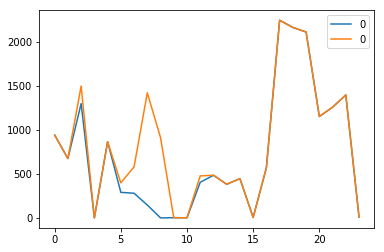

In [32]:
ax = pd.DataFrame(test_pred[1][0][0]).plot()
pd.DataFrame(test_gt[1][0][0]).plot(ax=ax)

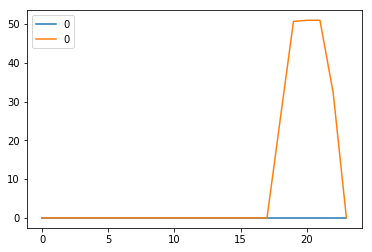

In [33]:
ax = pd.DataFrame(test_pred[1][3][0]).plot()
pd.DataFrame(test_gt[1][3][0]).plot(ax=ax)

In [17]:
test_error

{'dr': 69.228802093500178,
 'dw': 27.848078110630397,
 'fridge': 81.584834068736683,
 'hvac': 2.6248525653797152,
 'mw': 53.549970334987023}

In [83]:
for dataset in [2]:
    for cluster in [0]:
        for cur_fold in range(5):
            for latent in range(1, 21):
                for lr in [0.01, 0.1 ,1 ,2]:
                    for iters in range(100, 2600, 400):
                        print("python baseline-stf-nested.py {} {} {} {} {}& ".format(dataset, cur_fold, latent, lr, iters))
                        line = "python baseline-stf-nested.py {} {} {} {} {}& \n".format(dataset, cur_fold, latent, lr, iters)
                        with open('../code/stf-2.sh', 'a') as the_file:
#                             the_file.write("#!bin/bash \n")
                            the_file.write(line)


python baseline-stf-nested.py 2 0 1 0.01 100& 
python baseline-stf-nested.py 2 0 1 0.01 500& 
python baseline-stf-nested.py 2 0 1 0.01 900& 
python baseline-stf-nested.py 2 0 1 0.01 1300& 
python baseline-stf-nested.py 2 0 1 0.01 1700& 
python baseline-stf-nested.py 2 0 1 0.01 2100& 
python baseline-stf-nested.py 2 0 1 0.01 2500& 
python baseline-stf-nested.py 2 0 1 0.1 100& 
python baseline-stf-nested.py 2 0 1 0.1 500& 
python baseline-stf-nested.py 2 0 1 0.1 900& 
python baseline-stf-nested.py 2 0 1 0.1 1300& 
python baseline-stf-nested.py 2 0 1 0.1 1700& 
python baseline-stf-nested.py 2 0 1 0.1 2100& 
python baseline-stf-nested.py 2 0 1 0.1 2500& 
python baseline-stf-nested.py 2 0 1 1 100& 
python baseline-stf-nested.py 2 0 1 1 500& 
python baseline-stf-nested.py 2 0 1 1 900& 
python baseline-stf-nested.py 2 0 1 1 1300& 
python baseline-stf-nested.py 2 0 1 1 1700& 
python baseline-stf-nested.py 2 0 1 1 2100& 
python baseline-stf-nested.py 2 0 1 1 2500& 
python baseline-stf-nested.py

python baseline-stf-nested.py 2 0 9 0.1 2100& 
python baseline-stf-nested.py 2 0 9 0.1 2500& 
python baseline-stf-nested.py 2 0 9 1 100& 
python baseline-stf-nested.py 2 0 9 1 500& 
python baseline-stf-nested.py 2 0 9 1 900& 
python baseline-stf-nested.py 2 0 9 1 1300& 
python baseline-stf-nested.py 2 0 9 1 1700& 
python baseline-stf-nested.py 2 0 9 1 2100& 
python baseline-stf-nested.py 2 0 9 1 2500& 
python baseline-stf-nested.py 2 0 9 2 100& 
python baseline-stf-nested.py 2 0 9 2 500& 
python baseline-stf-nested.py 2 0 9 2 900& 
python baseline-stf-nested.py 2 0 9 2 1300& 
python baseline-stf-nested.py 2 0 9 2 1700& 
python baseline-stf-nested.py 2 0 9 2 2100& 
python baseline-stf-nested.py 2 0 9 2 2500& 
python baseline-stf-nested.py 2 0 10 0.01 100& 
python baseline-stf-nested.py 2 0 10 0.01 500& 
python baseline-stf-nested.py 2 0 10 0.01 900& 
python baseline-stf-nested.py 2 0 10 0.01 1300& 
python baseline-stf-nested.py 2 0 10 0.01 1700& 
python baseline-stf-nested.py 2 0 10 0.0

python baseline-stf-nested.py 2 0 18 1 100& 
python baseline-stf-nested.py 2 0 18 1 500& 
python baseline-stf-nested.py 2 0 18 1 900& 
python baseline-stf-nested.py 2 0 18 1 1300& 
python baseline-stf-nested.py 2 0 18 1 1700& 
python baseline-stf-nested.py 2 0 18 1 2100& 
python baseline-stf-nested.py 2 0 18 1 2500& 
python baseline-stf-nested.py 2 0 18 2 100& 
python baseline-stf-nested.py 2 0 18 2 500& 
python baseline-stf-nested.py 2 0 18 2 900& 
python baseline-stf-nested.py 2 0 18 2 1300& 
python baseline-stf-nested.py 2 0 18 2 1700& 
python baseline-stf-nested.py 2 0 18 2 2100& 
python baseline-stf-nested.py 2 0 18 2 2500& 
python baseline-stf-nested.py 2 0 19 0.01 100& 
python baseline-stf-nested.py 2 0 19 0.01 500& 
python baseline-stf-nested.py 2 0 19 0.01 900& 
python baseline-stf-nested.py 2 0 19 0.01 1300& 
python baseline-stf-nested.py 2 0 19 0.01 1700& 
python baseline-stf-nested.py 2 0 19 0.01 2100& 
python baseline-stf-nested.py 2 0 19 0.01 2500& 
python baseline-stf-ne

python baseline-stf-nested.py 2 1 7 0.1 2100& 
python baseline-stf-nested.py 2 1 7 0.1 2500& 
python baseline-stf-nested.py 2 1 7 1 100& 
python baseline-stf-nested.py 2 1 7 1 500& 
python baseline-stf-nested.py 2 1 7 1 900& 
python baseline-stf-nested.py 2 1 7 1 1300& 
python baseline-stf-nested.py 2 1 7 1 1700& 
python baseline-stf-nested.py 2 1 7 1 2100& 
python baseline-stf-nested.py 2 1 7 1 2500& 
python baseline-stf-nested.py 2 1 7 2 100& 
python baseline-stf-nested.py 2 1 7 2 500& 
python baseline-stf-nested.py 2 1 7 2 900& 
python baseline-stf-nested.py 2 1 7 2 1300& 
python baseline-stf-nested.py 2 1 7 2 1700& 
python baseline-stf-nested.py 2 1 7 2 2100& 
python baseline-stf-nested.py 2 1 7 2 2500& 
python baseline-stf-nested.py 2 1 8 0.01 100& 
python baseline-stf-nested.py 2 1 8 0.01 500& 
python baseline-stf-nested.py 2 1 8 0.01 900& 
python baseline-stf-nested.py 2 1 8 0.01 1300& 
python baseline-stf-nested.py 2 1 8 0.01 1700& 
python baseline-stf-nested.py 2 1 8 0.01 2100

python baseline-stf-nested.py 2 1 17 0.01 1300& 
python baseline-stf-nested.py 2 1 17 0.01 1700& 
python baseline-stf-nested.py 2 1 17 0.01 2100& 
python baseline-stf-nested.py 2 1 17 0.01 2500& 
python baseline-stf-nested.py 2 1 17 0.1 100& 
python baseline-stf-nested.py 2 1 17 0.1 500& 
python baseline-stf-nested.py 2 1 17 0.1 900& 
python baseline-stf-nested.py 2 1 17 0.1 1300& 
python baseline-stf-nested.py 2 1 17 0.1 1700& 
python baseline-stf-nested.py 2 1 17 0.1 2100& 
python baseline-stf-nested.py 2 1 17 0.1 2500& 
python baseline-stf-nested.py 2 1 17 1 100& 
python baseline-stf-nested.py 2 1 17 1 500& 
python baseline-stf-nested.py 2 1 17 1 900& 
python baseline-stf-nested.py 2 1 17 1 1300& 
python baseline-stf-nested.py 2 1 17 1 1700& 
python baseline-stf-nested.py 2 1 17 1 2100& 
python baseline-stf-nested.py 2 1 17 1 2500& 
python baseline-stf-nested.py 2 1 17 2 100& 
python baseline-stf-nested.py 2 1 17 2 500& 
python baseline-stf-nested.py 2 1 17 2 900& 
python baseline-s

python baseline-stf-nested.py 2 2 6 0.1 2100& 
python baseline-stf-nested.py 2 2 6 0.1 2500& 
python baseline-stf-nested.py 2 2 6 1 100& 
python baseline-stf-nested.py 2 2 6 1 500& 
python baseline-stf-nested.py 2 2 6 1 900& 
python baseline-stf-nested.py 2 2 6 1 1300& 
python baseline-stf-nested.py 2 2 6 1 1700& 
python baseline-stf-nested.py 2 2 6 1 2100& 
python baseline-stf-nested.py 2 2 6 1 2500& 
python baseline-stf-nested.py 2 2 6 2 100& 
python baseline-stf-nested.py 2 2 6 2 500& 
python baseline-stf-nested.py 2 2 6 2 900& 
python baseline-stf-nested.py 2 2 6 2 1300& 
python baseline-stf-nested.py 2 2 6 2 1700& 
python baseline-stf-nested.py 2 2 6 2 2100& 
python baseline-stf-nested.py 2 2 6 2 2500& 
python baseline-stf-nested.py 2 2 7 0.01 100& 
python baseline-stf-nested.py 2 2 7 0.01 500& 
python baseline-stf-nested.py 2 2 7 0.01 900& 
python baseline-stf-nested.py 2 2 7 0.01 1300& 
python baseline-stf-nested.py 2 2 7 0.01 1700& 
python baseline-stf-nested.py 2 2 7 0.01 2100

python baseline-stf-nested.py 2 2 15 1 100& 
python baseline-stf-nested.py 2 2 15 1 500& 
python baseline-stf-nested.py 2 2 15 1 900& 
python baseline-stf-nested.py 2 2 15 1 1300& 
python baseline-stf-nested.py 2 2 15 1 1700& 
python baseline-stf-nested.py 2 2 15 1 2100& 
python baseline-stf-nested.py 2 2 15 1 2500& 
python baseline-stf-nested.py 2 2 15 2 100& 
python baseline-stf-nested.py 2 2 15 2 500& 
python baseline-stf-nested.py 2 2 15 2 900& 
python baseline-stf-nested.py 2 2 15 2 1300& 
python baseline-stf-nested.py 2 2 15 2 1700& 
python baseline-stf-nested.py 2 2 15 2 2100& 
python baseline-stf-nested.py 2 2 15 2 2500& 
python baseline-stf-nested.py 2 2 16 0.01 100& 
python baseline-stf-nested.py 2 2 16 0.01 500& 
python baseline-stf-nested.py 2 2 16 0.01 900& 
python baseline-stf-nested.py 2 2 16 0.01 1300& 
python baseline-stf-nested.py 2 2 16 0.01 1700& 
python baseline-stf-nested.py 2 2 16 0.01 2100& 
python baseline-stf-nested.py 2 2 16 0.01 2500& 
python baseline-stf-ne

python baseline-stf-nested.py 2 3 5 0.1 1700& 
python baseline-stf-nested.py 2 3 5 0.1 2100& 
python baseline-stf-nested.py 2 3 5 0.1 2500& 
python baseline-stf-nested.py 2 3 5 1 100& 
python baseline-stf-nested.py 2 3 5 1 500& 
python baseline-stf-nested.py 2 3 5 1 900& 
python baseline-stf-nested.py 2 3 5 1 1300& 
python baseline-stf-nested.py 2 3 5 1 1700& 
python baseline-stf-nested.py 2 3 5 1 2100& 
python baseline-stf-nested.py 2 3 5 1 2500& 
python baseline-stf-nested.py 2 3 5 2 100& 
python baseline-stf-nested.py 2 3 5 2 500& 
python baseline-stf-nested.py 2 3 5 2 900& 
python baseline-stf-nested.py 2 3 5 2 1300& 
python baseline-stf-nested.py 2 3 5 2 1700& 
python baseline-stf-nested.py 2 3 5 2 2100& 
python baseline-stf-nested.py 2 3 5 2 2500& 
python baseline-stf-nested.py 2 3 6 0.01 100& 
python baseline-stf-nested.py 2 3 6 0.01 500& 
python baseline-stf-nested.py 2 3 6 0.01 900& 
python baseline-stf-nested.py 2 3 6 0.01 1300& 
python baseline-stf-nested.py 2 3 6 0.01 1700&

python baseline-stf-nested.py 2 3 15 0.01 2500& 
python baseline-stf-nested.py 2 3 15 0.1 100& 
python baseline-stf-nested.py 2 3 15 0.1 500& 
python baseline-stf-nested.py 2 3 15 0.1 900& 
python baseline-stf-nested.py 2 3 15 0.1 1300& 
python baseline-stf-nested.py 2 3 15 0.1 1700& 
python baseline-stf-nested.py 2 3 15 0.1 2100& 
python baseline-stf-nested.py 2 3 15 0.1 2500& 
python baseline-stf-nested.py 2 3 15 1 100& 
python baseline-stf-nested.py 2 3 15 1 500& 
python baseline-stf-nested.py 2 3 15 1 900& 
python baseline-stf-nested.py 2 3 15 1 1300& 
python baseline-stf-nested.py 2 3 15 1 1700& 
python baseline-stf-nested.py 2 3 15 1 2100& 
python baseline-stf-nested.py 2 3 15 1 2500& 
python baseline-stf-nested.py 2 3 15 2 100& 
python baseline-stf-nested.py 2 3 15 2 500& 
python baseline-stf-nested.py 2 3 15 2 900& 
python baseline-stf-nested.py 2 3 15 2 1300& 
python baseline-stf-nested.py 2 3 15 2 1700& 
python baseline-stf-nested.py 2 3 15 2 2100& 
python baseline-stf-nested

python baseline-stf-nested.py 2 4 4 0.01 1700& 
python baseline-stf-nested.py 2 4 4 0.01 2100& 
python baseline-stf-nested.py 2 4 4 0.01 2500& 
python baseline-stf-nested.py 2 4 4 0.1 100& 
python baseline-stf-nested.py 2 4 4 0.1 500& 
python baseline-stf-nested.py 2 4 4 0.1 900& 
python baseline-stf-nested.py 2 4 4 0.1 1300& 
python baseline-stf-nested.py 2 4 4 0.1 1700& 
python baseline-stf-nested.py 2 4 4 0.1 2100& 
python baseline-stf-nested.py 2 4 4 0.1 2500& 
python baseline-stf-nested.py 2 4 4 1 100& 
python baseline-stf-nested.py 2 4 4 1 500& 
python baseline-stf-nested.py 2 4 4 1 900& 
python baseline-stf-nested.py 2 4 4 1 1300& 
python baseline-stf-nested.py 2 4 4 1 1700& 
python baseline-stf-nested.py 2 4 4 1 2100& 
python baseline-stf-nested.py 2 4 4 1 2500& 
python baseline-stf-nested.py 2 4 4 2 100& 
python baseline-stf-nested.py 2 4 4 2 500& 
python baseline-stf-nested.py 2 4 4 2 900& 
python baseline-stf-nested.py 2 4 4 2 1300& 
python baseline-stf-nested.py 2 4 4 2 170

python baseline-stf-nested.py 2 4 12 2 500& 
python baseline-stf-nested.py 2 4 12 2 900& 
python baseline-stf-nested.py 2 4 12 2 1300& 
python baseline-stf-nested.py 2 4 12 2 1700& 
python baseline-stf-nested.py 2 4 12 2 2100& 
python baseline-stf-nested.py 2 4 12 2 2500& 
python baseline-stf-nested.py 2 4 13 0.01 100& 
python baseline-stf-nested.py 2 4 13 0.01 500& 
python baseline-stf-nested.py 2 4 13 0.01 900& 
python baseline-stf-nested.py 2 4 13 0.01 1300& 
python baseline-stf-nested.py 2 4 13 0.01 1700& 
python baseline-stf-nested.py 2 4 13 0.01 2100& 
python baseline-stf-nested.py 2 4 13 0.01 2500& 
python baseline-stf-nested.py 2 4 13 0.1 100& 
python baseline-stf-nested.py 2 4 13 0.1 500& 
python baseline-stf-nested.py 2 4 13 0.1 900& 
python baseline-stf-nested.py 2 4 13 0.1 1300& 
python baseline-stf-nested.py 2 4 13 0.1 1700& 
python baseline-stf-nested.py 2 4 13 0.1 2100& 
python baseline-stf-nested.py 2 4 13 0.1 2500& 
python baseline-stf-nested.py 2 4 13 1 100& 
python b